In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.3 MB/s eta 0:00:00


# Import important libraries

In [133]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import pickle
import dill
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [127]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Import test pipline

In [32]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as file:
    test_pipeline = dill.load(file)

# Preprocess test data using test pipline

In [35]:
X = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test')
X_test = test_pipeline.transform(X)
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')

# ***Classification(churn prediction) Baselines***

# Create binary classification class for evaluation model in all terms

In [78]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        """Initialize the evaluation class with true labels and predicted labels."""
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def classification_report(self):
        """Generate and return the classification report."""
        report = classification_report(self.y_test, self.y_pred)
        print(report)

    def confusion_matrix(self):
        """Compute and return the confusion matrix."""
        cm = confusion_matrix(self.y_test, self.y_pred)
        return cm

    def visualize_confusion_matrix(self):
        """Visualize the confusion matrix using a heatmap."""
        cm = self.confusion_matrix()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_score(self):
        """Calculate and plot the ROC curve, along with the AUC score."""
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")

        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        print('ROC AUC Score:', auc_score)

        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_f1(self):
        """Calculate and print precision, recall, and F1 score."""
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1 Score:', f1)

    def precision_recall_curve_plot(self):
        """Plot the Precision-Recall curve."""
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

# Create different type of baselines for classification(churn prediction) for future comarison

In [119]:
class ClassificationBaseline:
    def __init__(self, y_test):
        self.positive_percendage = y_test.value_counts()[1] / len(y_test)
        self.negative_percendage = y_test.value_counts()[0] / len(y_test)
        self.row_number = y_test.shape[0]

    def baseline_proba(self):
        n = self.row_number
        n_ones = int(n * self.positive_percendage)
        n_zeros = n - n_ones

        data = [1] * n_ones + [0] * n_zeros
        np.random.shuffle(data)
        random_series = pd.Series(data)

        return random_series
    def only_negatives(self):
        data = [0] * self.row_number
        random_series = pd.Series(data)

        return random_series

# Create evaluation object

In [120]:
classification_baseline = ClassificationBaseline(y_test['target_event'])

# Get predictions from all baselines

In [121]:
y_pred_proba = classification_baseline.baseline_proba()
y_pred_neg = classification_baseline.only_negatives()

# Get classification reports for both

In [122]:
report_proba = BinaryClassificationEvaluation(y_test['target_event'], y_pred_proba)
report_neg = BinaryClassificationEvaluation(y_test['target_event'], y_pred_neg)

# Classification report for baseline which predicts zeroes and ones according to the percentages in test data

In [123]:
report_proba.classification_report()

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     15296
           1       0.32      0.32      0.32      7226

    accuracy                           0.56     22522
   macro avg       0.50      0.50      0.50     22522
weighted avg       0.56      0.56      0.56     22522



In [128]:
report_neg.classification_report()

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     15296
           1       0.00      0.00      0.00      7226

    accuracy                           0.68     22522
   macro avg       0.34      0.50      0.40     22522
weighted avg       0.46      0.68      0.55     22522



# ***Regression(target_actual_profit prediction) Baselines***

In [134]:
class RegressionEvaluation:
    def __init__(self, y_test, y_pred):
        """Initialize the evaluation class with true labels and predicted labels."""
        self.y_test = y_test
        self.y_pred = y_pred

    def mean_absolute_error(self):
        """Calculate and return Mean Absolute Error."""
        mae = mean_absolute_error(self.y_test, self.y_pred)
        print('Mean Absolute Error (MAE):', mae)
        return mae

    def mean_squared_error(self):
        """Calculate and return Mean Squared Error."""
        mse = mean_squared_error(self.y_test, self.y_pred)
        print('Mean Squared Error (MSE):', mse)
        return mse

    def root_mean_squared_error(self):
        """Calculate and return Root Mean Squared Error."""
        rmse = np.sqrt(self.mean_squared_error())
        print('Root Mean Squared Error (RMSE):', rmse)
        return rmse

    def r_squared(self):
        """Calculate and return R-squared value."""
        r2 = r2_score(self.y_test, self.y_pred)
        print('R-squared (R²):', r2)
        return r2

    def residuals_plot(self):
        """Plot the residuals to check for homoscedasticity."""
        residuals = self.y_test - self.y_pred
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.y_pred, y=residuals)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals Plot')
        plt.show()

    def prediction_vs_actual_plot(self):
        """Plot predicted values vs actual values."""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, self.y_pred, alpha=0.6)
        plt.plot([self.y_test.min(), self.y_test.max()],
                 [self.y_test.min(), self.y_test.max()],
                 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Prediction vs Actual')
        plt.show()

    def evaluate(self):
        """Run all evaluations and print metrics."""
        self.mean_absolute_error()
        self.mean_squared_error()
        self.root_mean_squared_error()
        self.r_squared()
        self.residuals_plot()
        self.prediction_vs_actual_plot()


# Create regression baselines based on mean and median

In [139]:
class RegressionBaseline:
    def __init__(self, y_test):
        self.mean = y_test.mean()
        self.median = y_test.median()
    def mean_baseline(self):
        data = [self.mean] * len(y_test)
        random_series = pd.Series(data)

        return random_series
    def median_baseline(self):
        data = [self.median] * len(y_test)
        random_series = pd.Series(data)

        return random_series

# Create regression baseline object

In [140]:
regression_baseline = RegressionBaseline(y_test['target_actual_profit'])

# Make prediction abse on baselines

In [141]:
y_pred_mean = regression_baseline.mean_baseline()
y_pred_median = regression_baseline.median_baseline()

# Evaluate each baseline

In [142]:
regression_evaluation_mean = RegressionEvaluation(y_test['target_actual_profit'], y_pred_mean)
regression_evaluation_median = RegressionEvaluation(y_test['target_actual_profit'], y_pred_median)

Mean Absolute Error (MAE): 7.367837277545087
Mean Squared Error (MSE): 73.63727788039635
Mean Squared Error (MSE): 73.63727788039635
Root Mean Squared Error (RMSE): 8.581216573446701
R-squared (R²): 0.0


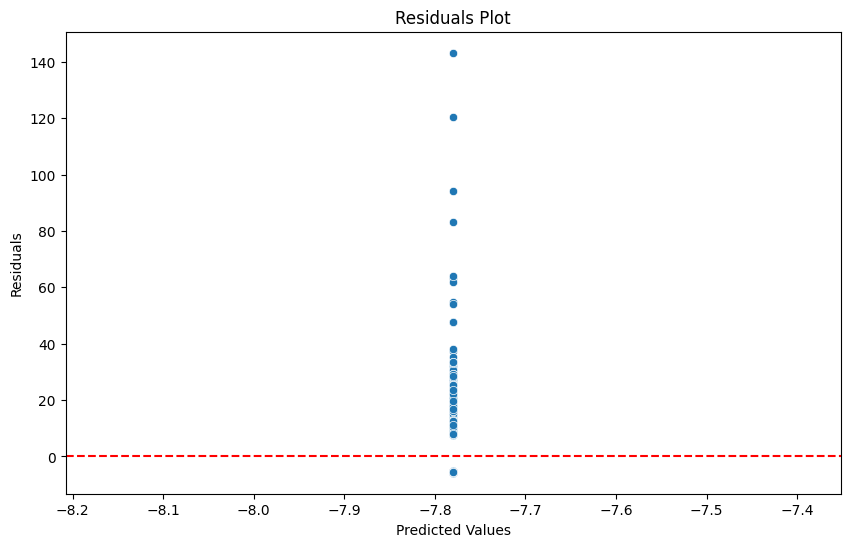

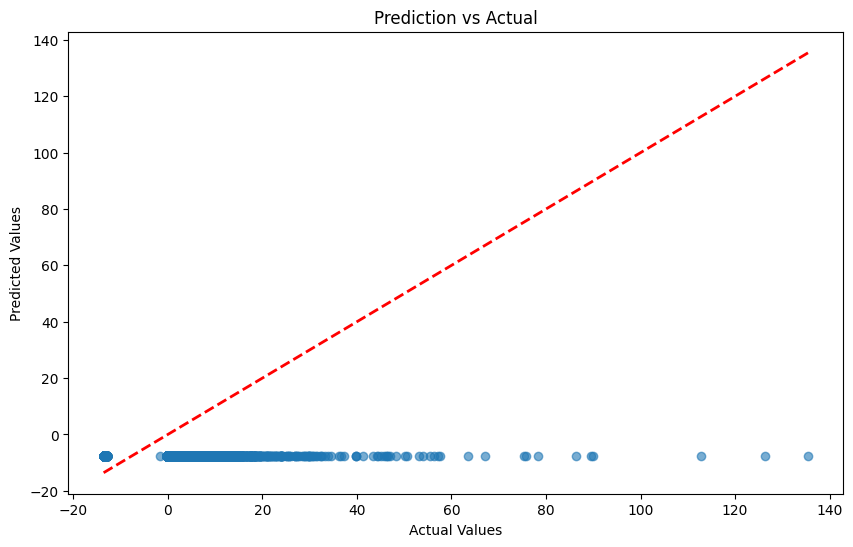

In [145]:
regression_evaluation_mean.mean_absolute_error()
regression_evaluation_mean.mean_squared_error()
regression_evaluation_mean.root_mean_squared_error()
regression_evaluation_mean.r_squared()
regression_evaluation_mean.residuals_plot()
regression_evaluation_mean.prediction_vs_actual_plot()

Mean Absolute Error (MAE): 5.465690012101304
Mean Squared Error (MSE): 102.44223534185325
Mean Squared Error (MSE): 102.44223534185325
Root Mean Squared Error (RMSE): 10.121375170492064
R-squared (R²): -0.3911735779837311


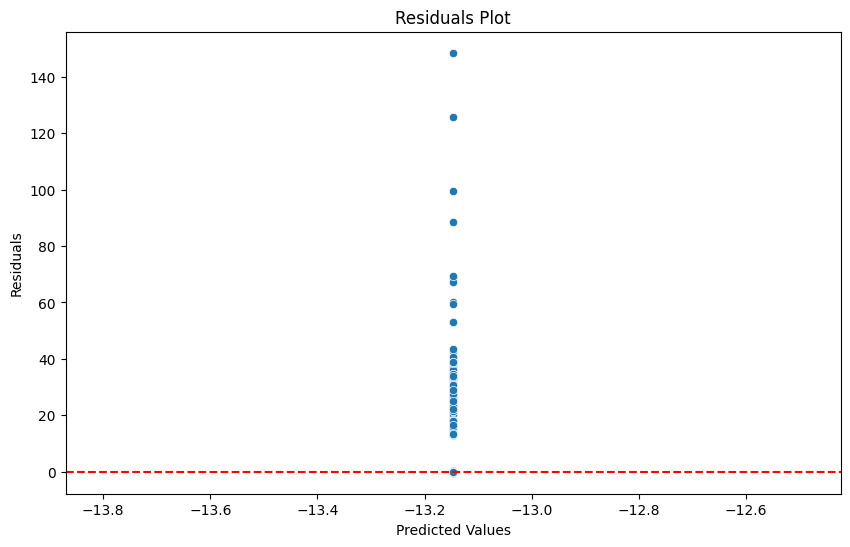

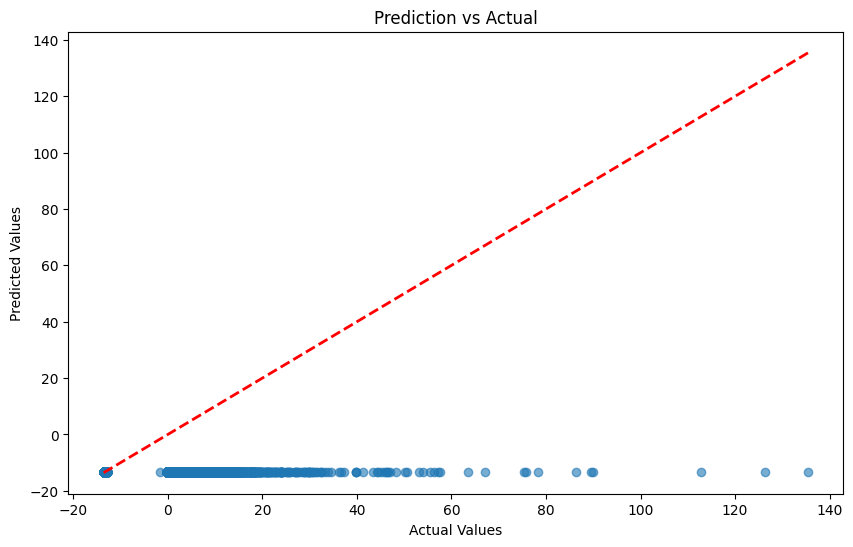

In [146]:
regression_evaluation_median.mean_absolute_error()
regression_evaluation_median.mean_squared_error()
regression_evaluation_median.root_mean_squared_error()
regression_evaluation_median.r_squared()
regression_evaluation_median.residuals_plot()
regression_evaluation_median.prediction_vs_actual_plot()